<a href="https://colab.research.google.com/github/dc3347/CompAspectsofRobotics/blob/main/Robotics_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

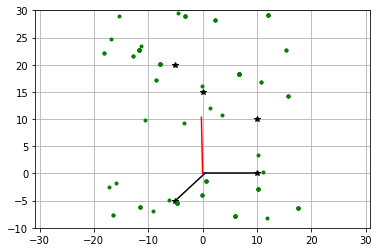

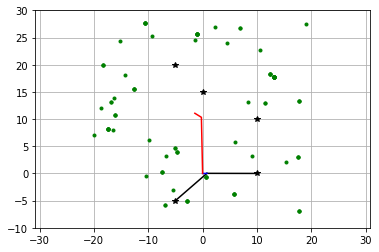

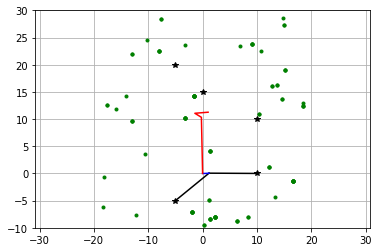

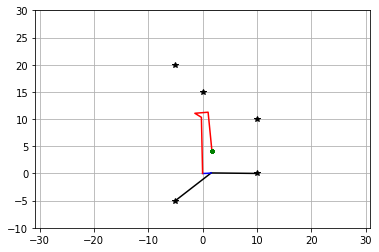

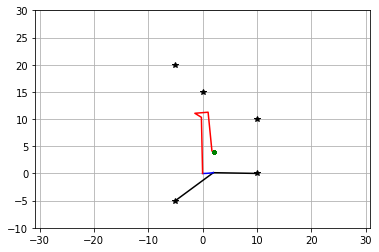

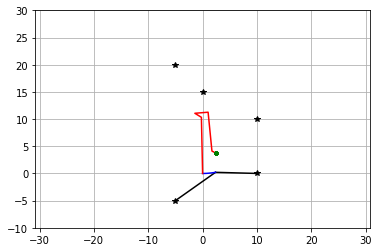

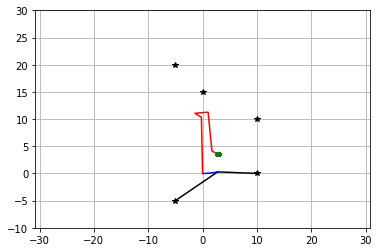

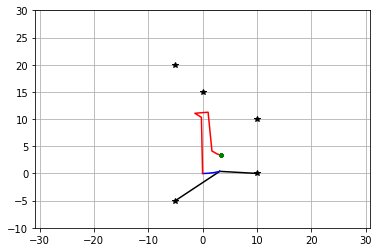

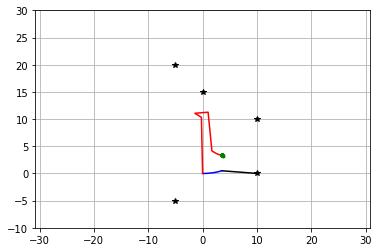

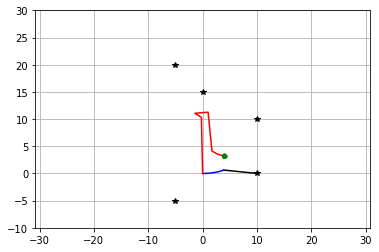

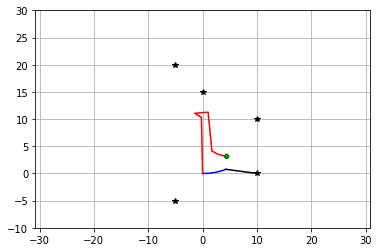

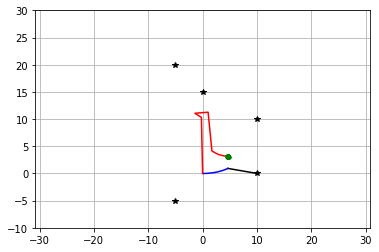

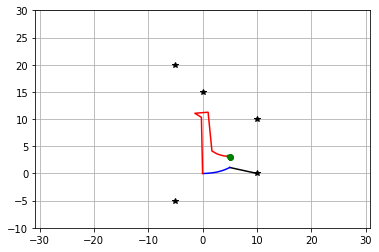

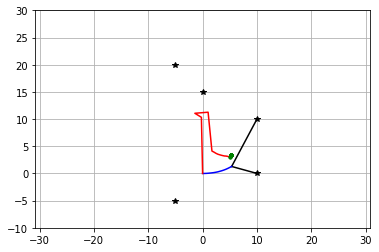

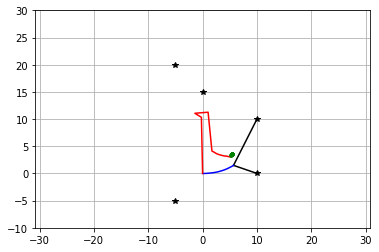

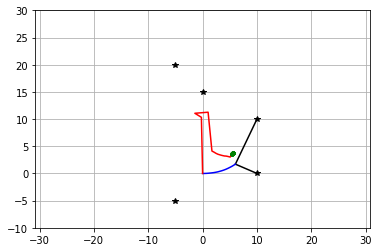

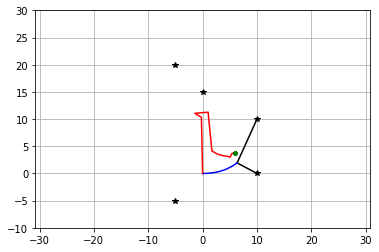

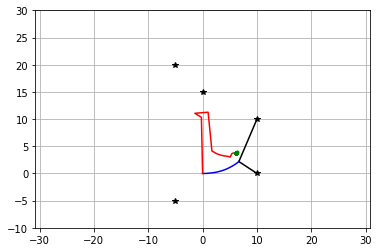

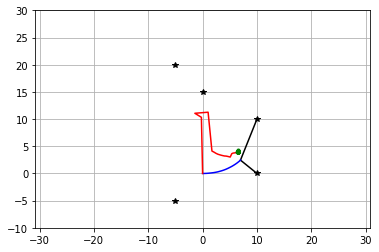

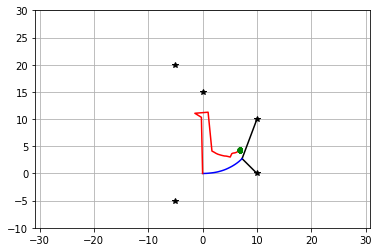

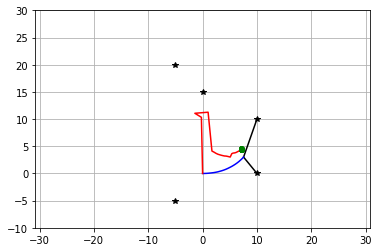

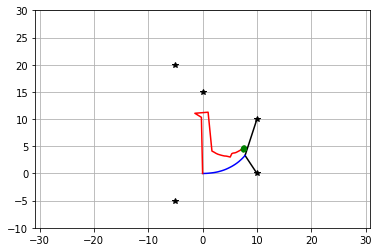

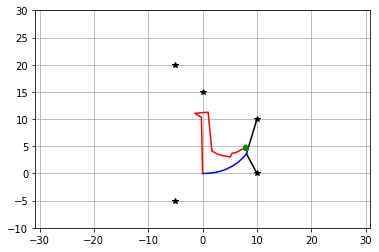

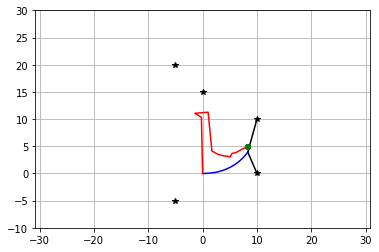

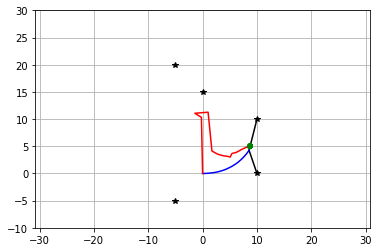

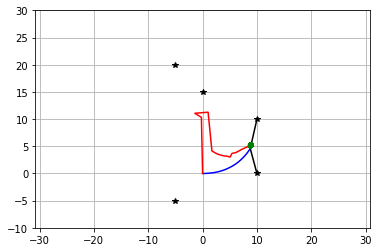

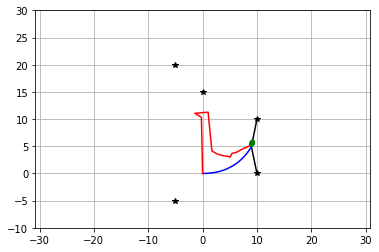

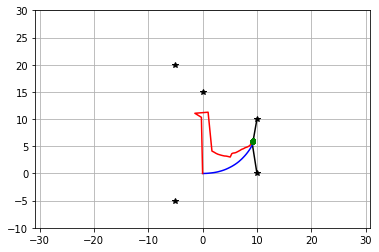

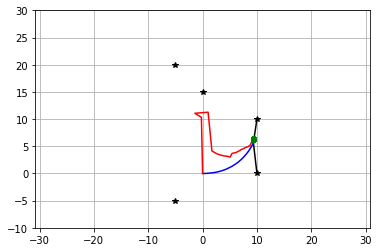

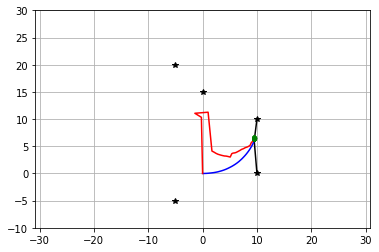

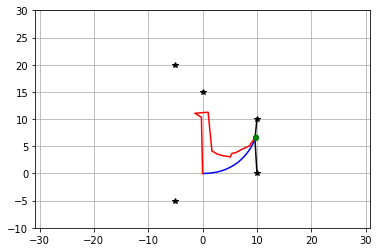

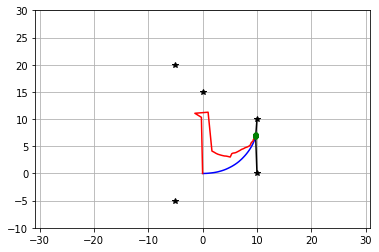

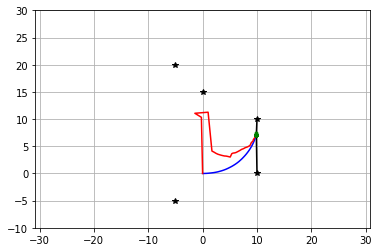

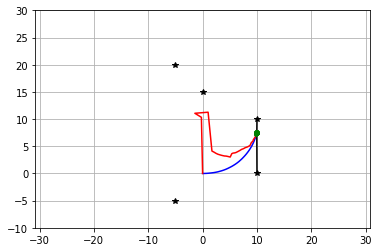

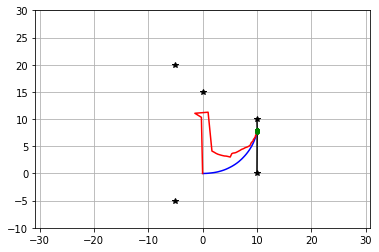

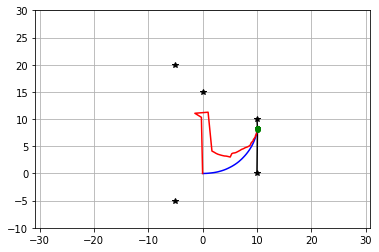

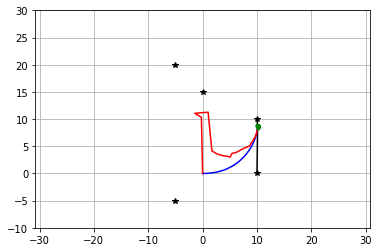

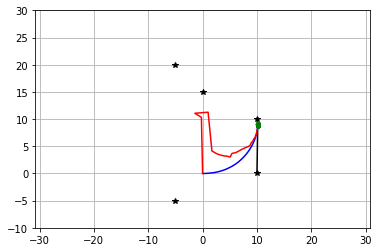

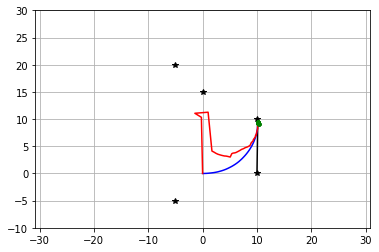

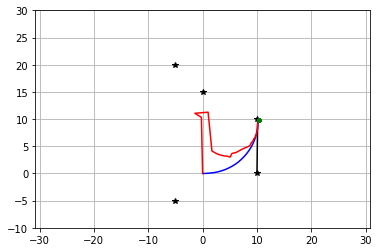

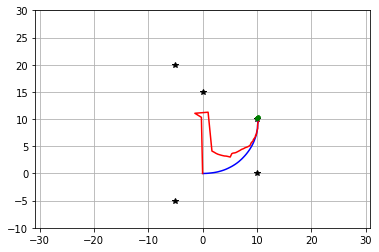

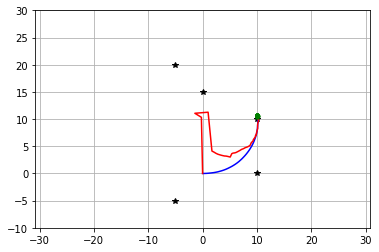

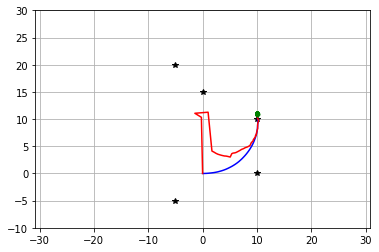

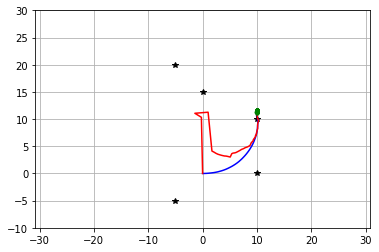

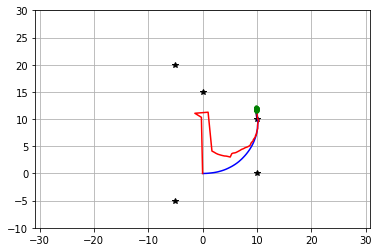

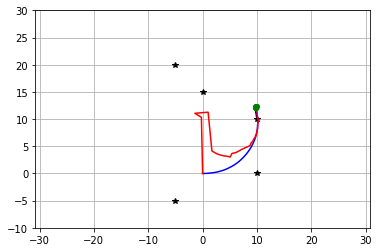

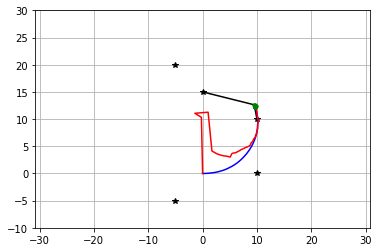

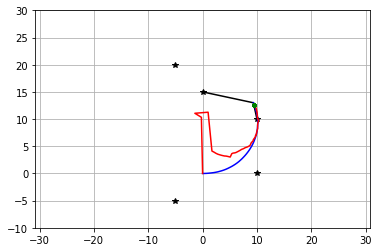

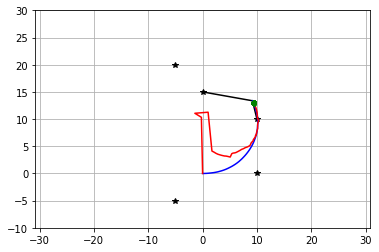

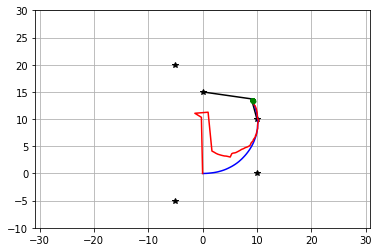

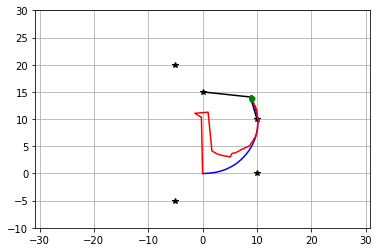

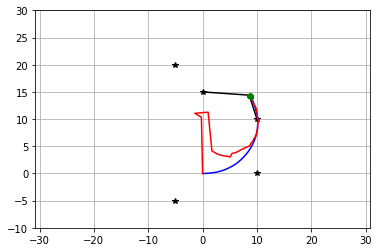

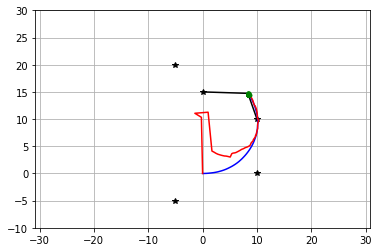

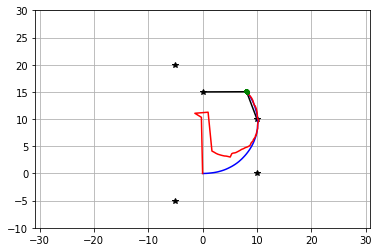

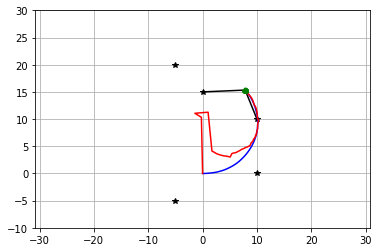

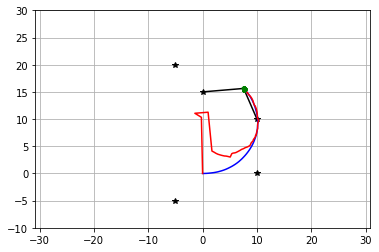

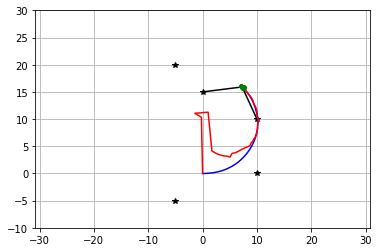

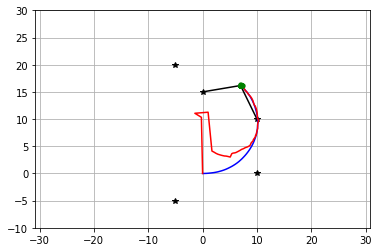

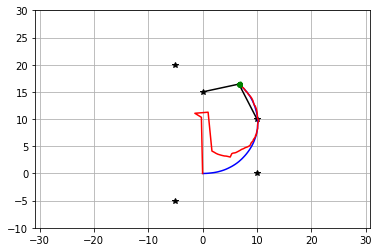

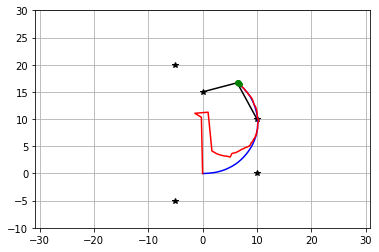

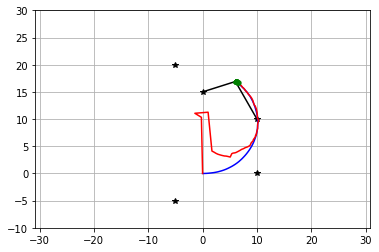

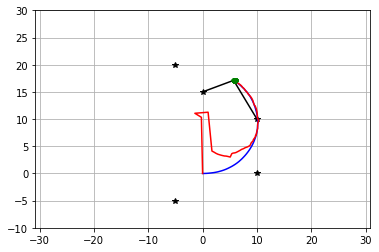

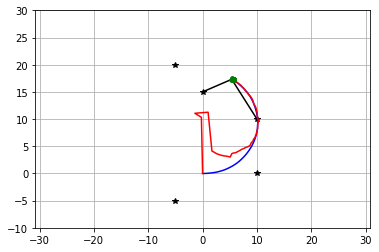

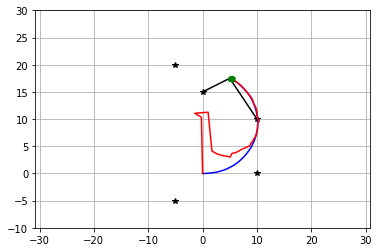

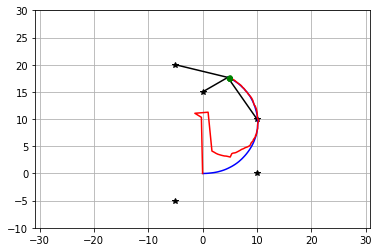

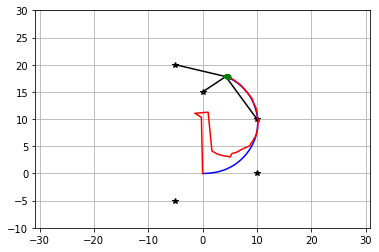

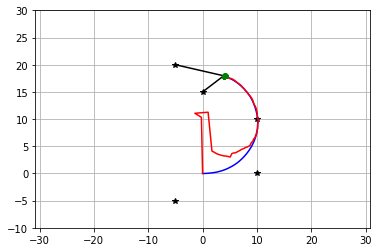

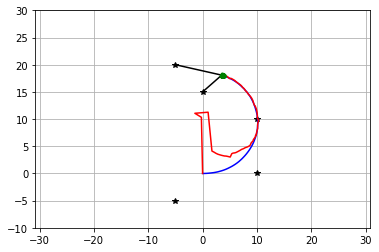

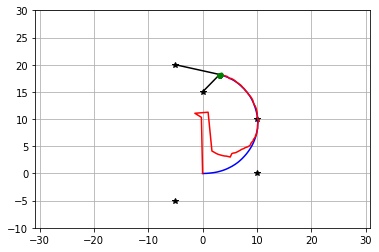

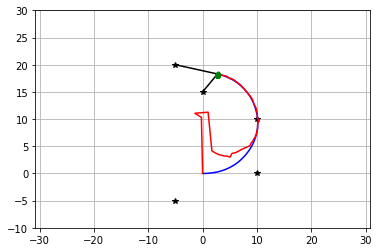

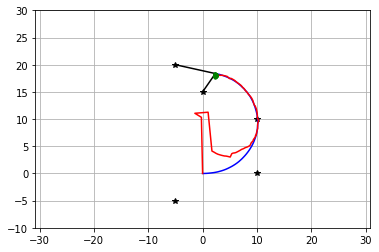

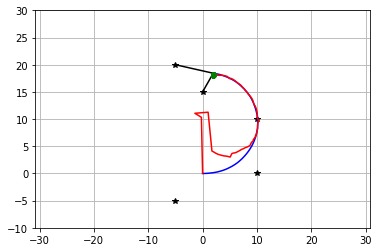

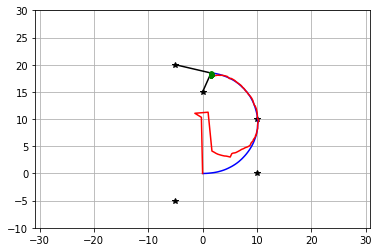

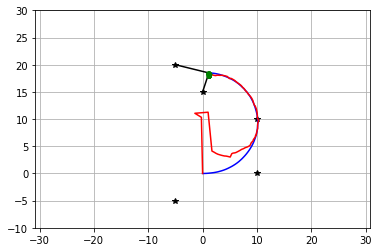

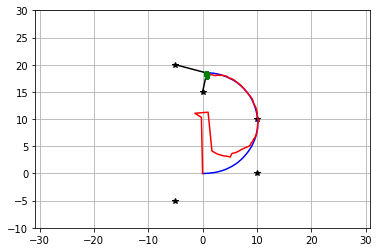

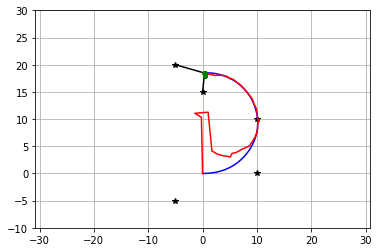

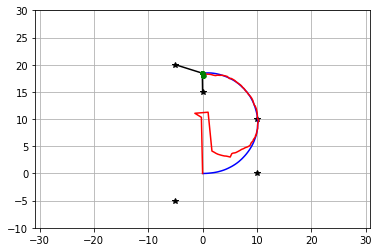

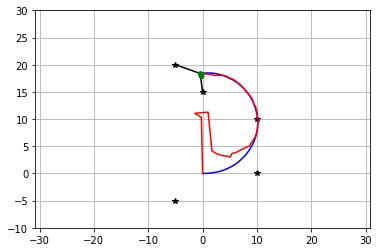

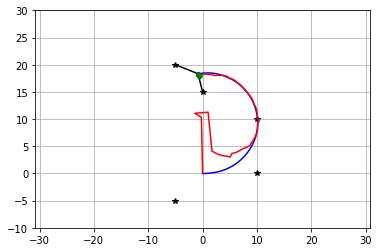

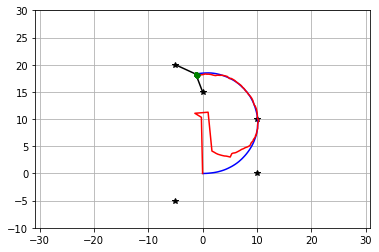

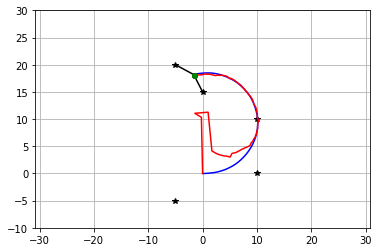

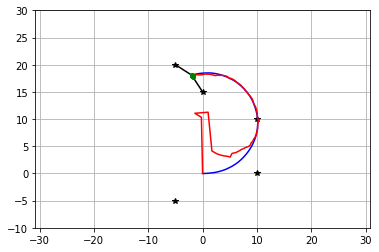

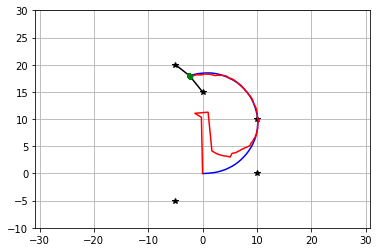

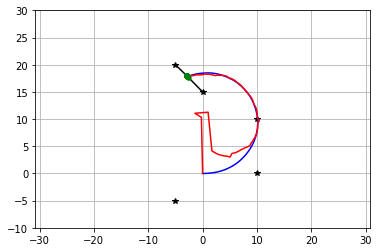

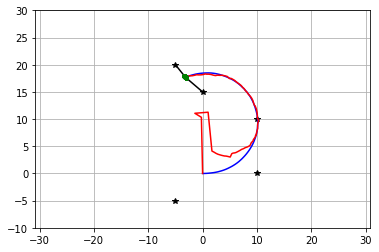

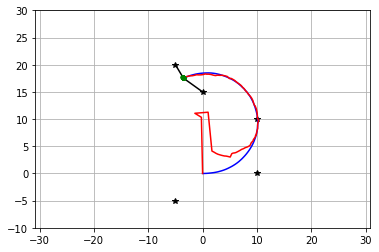

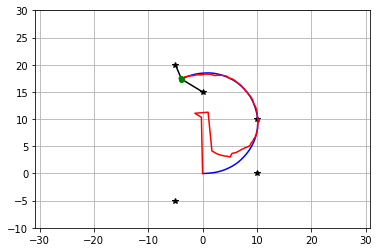

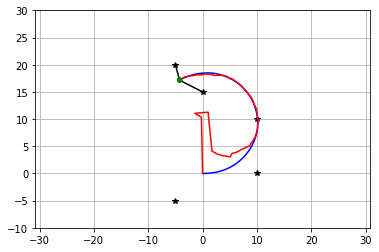

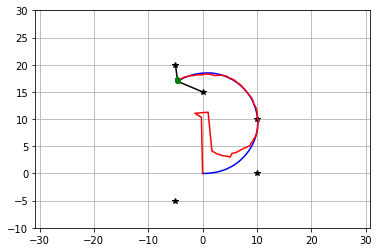

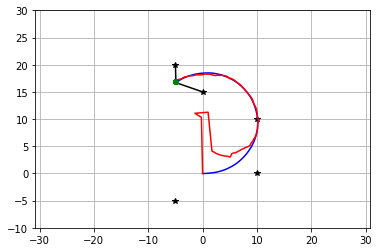

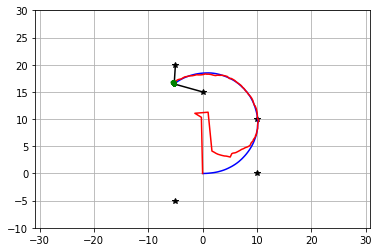

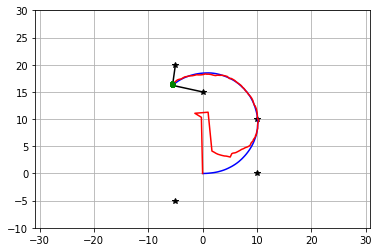

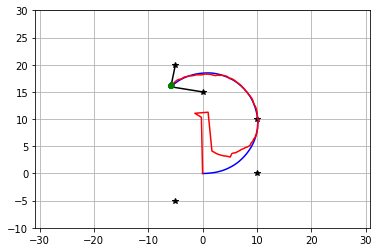

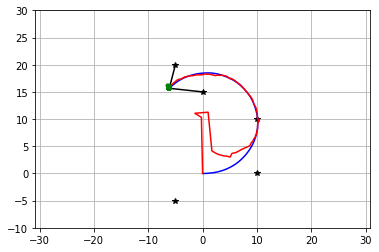

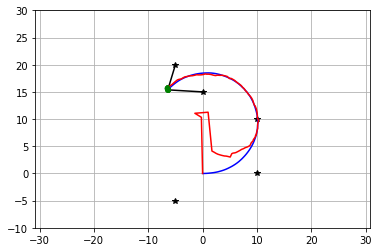

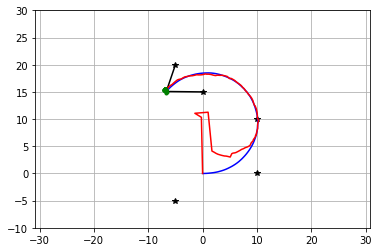

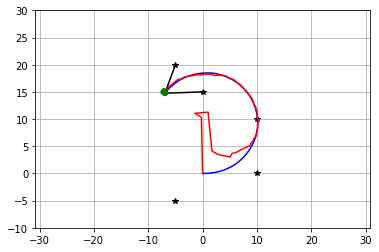

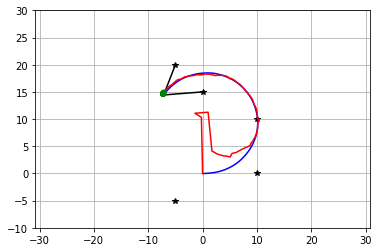

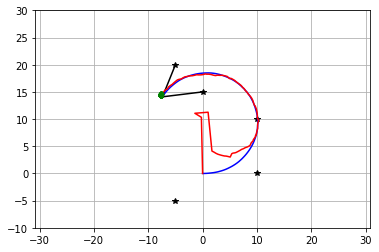

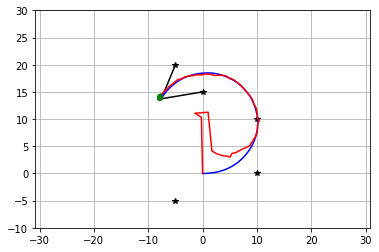

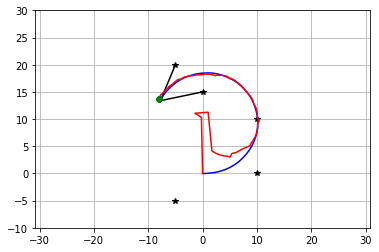

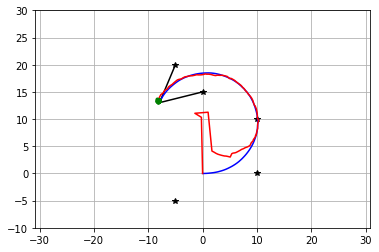

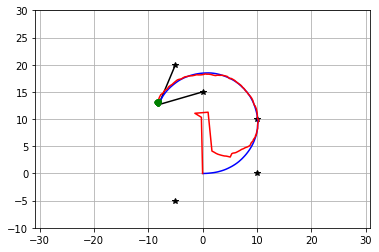

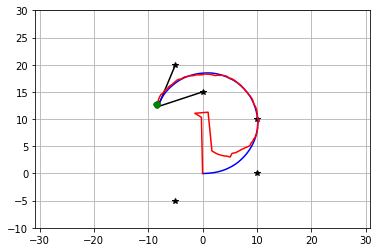

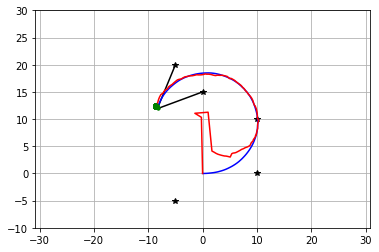

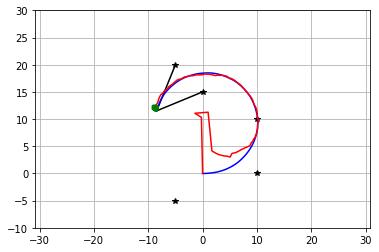

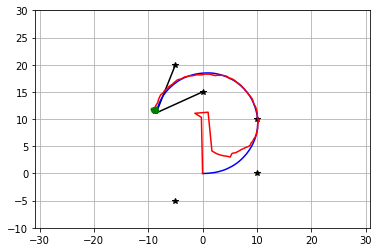

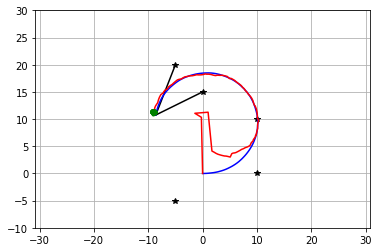

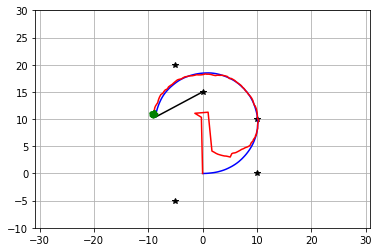

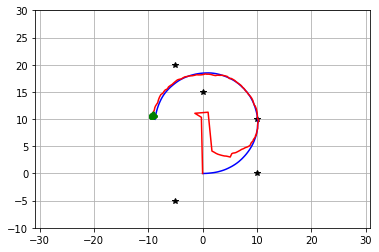

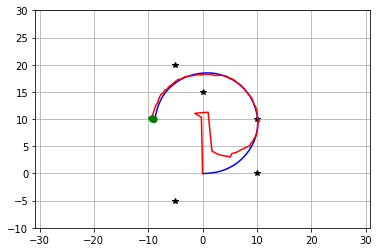

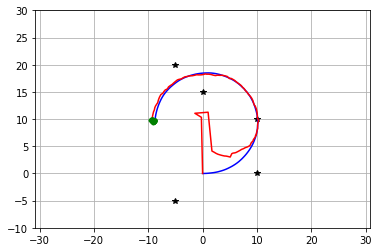

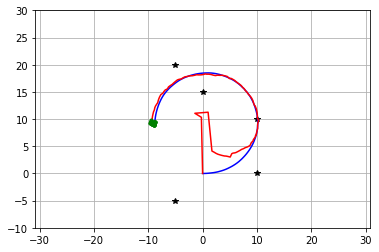

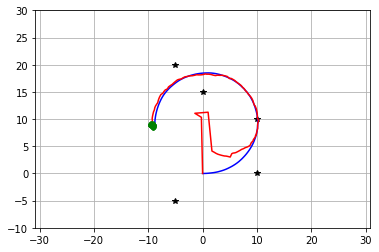

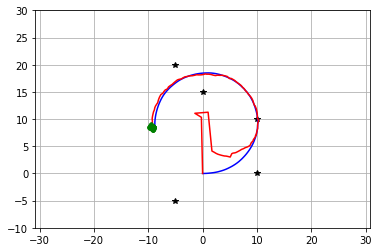

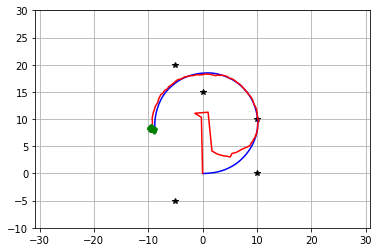

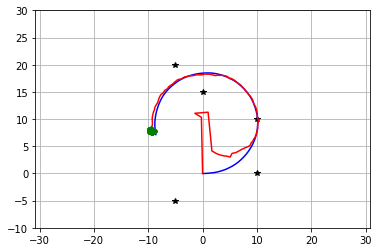

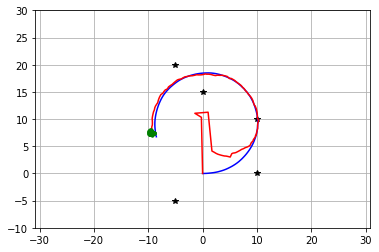

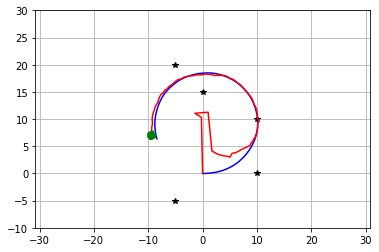

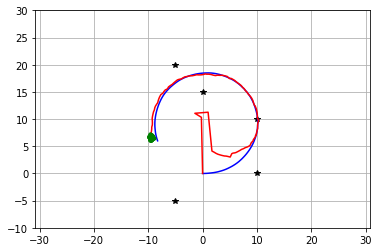

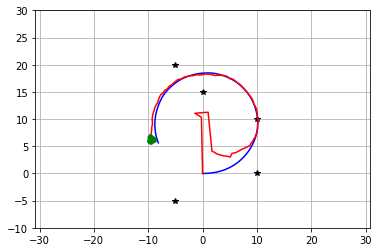

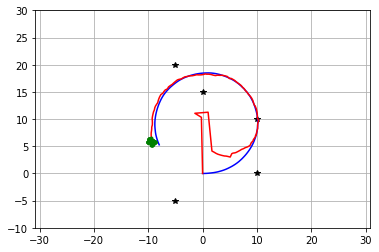

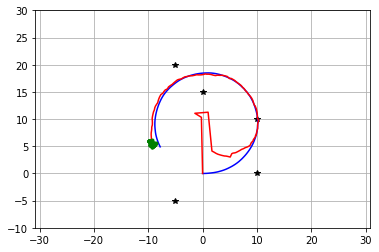

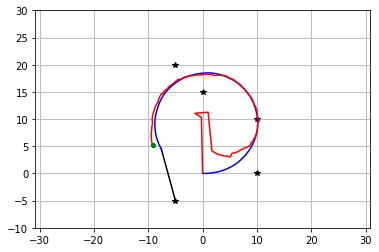

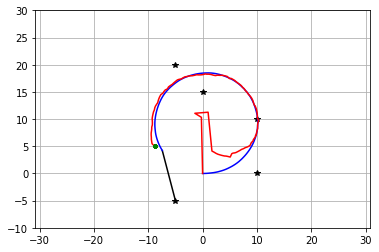

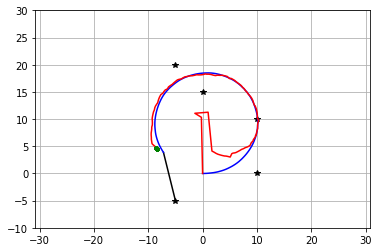

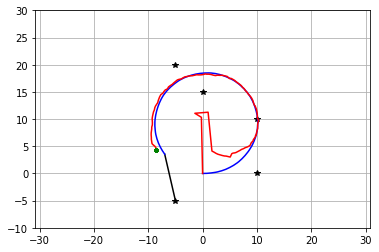

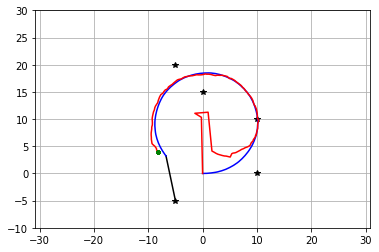

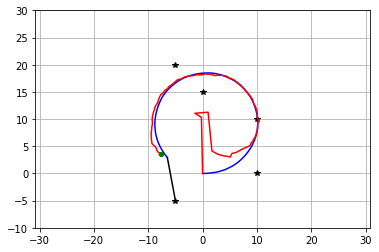

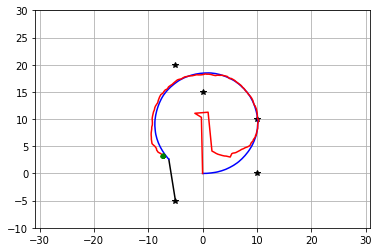

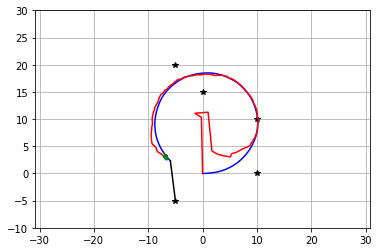

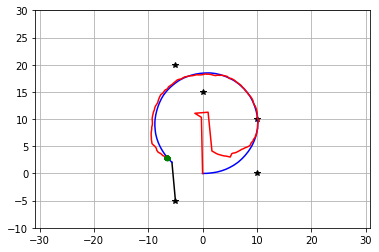

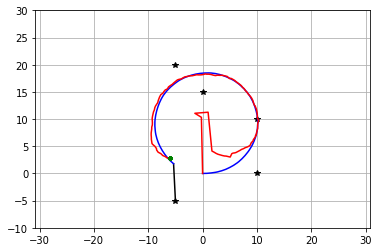

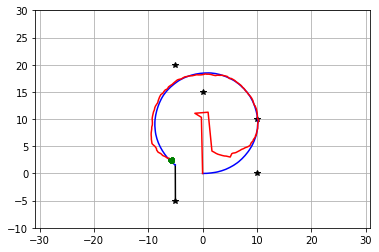

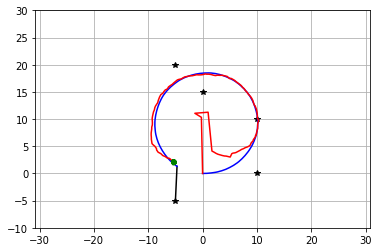

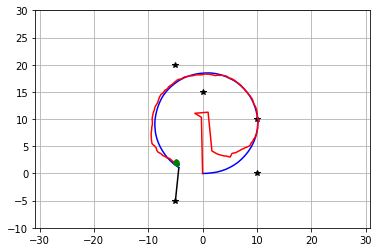

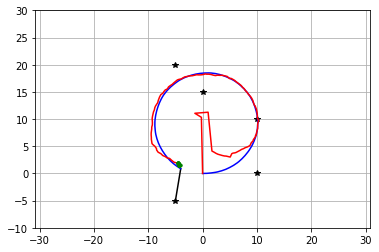

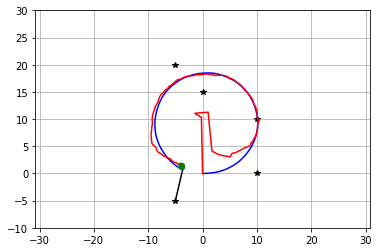

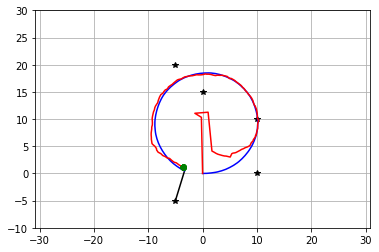

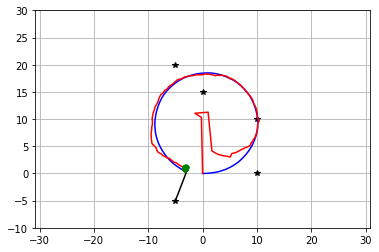

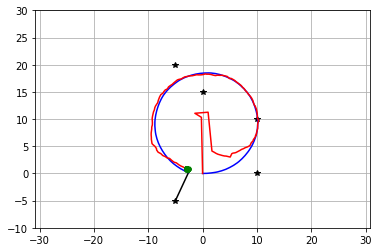

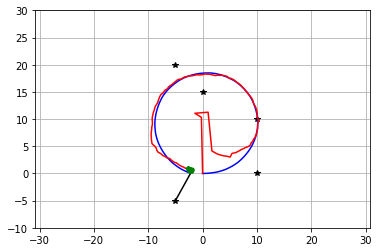

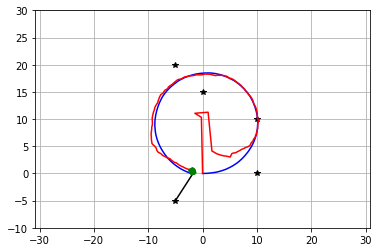

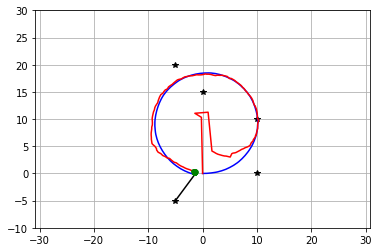

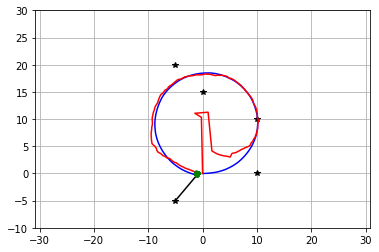

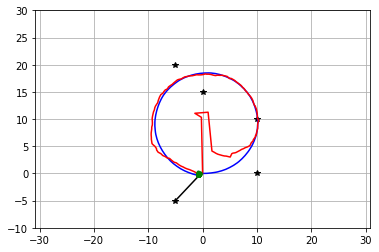

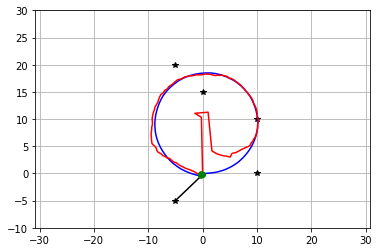

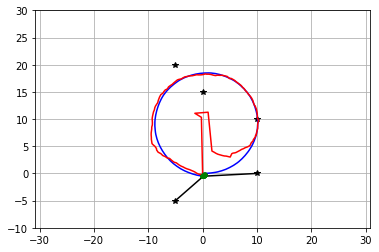

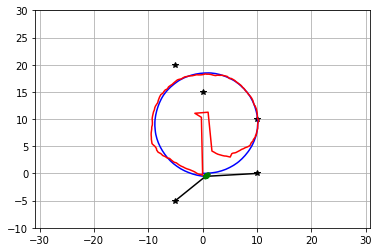

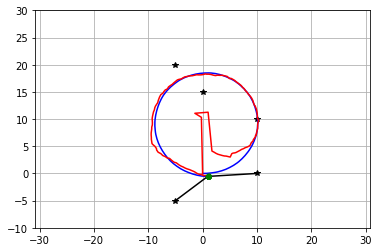

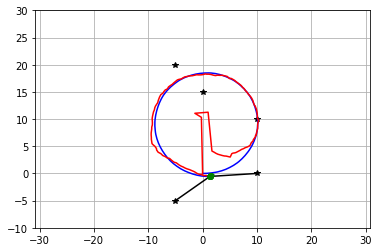

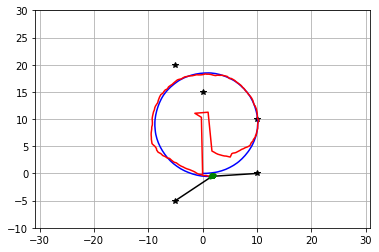

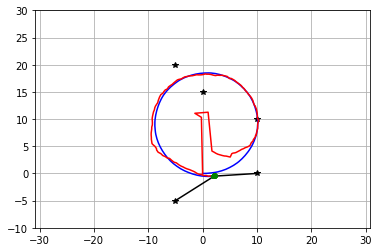

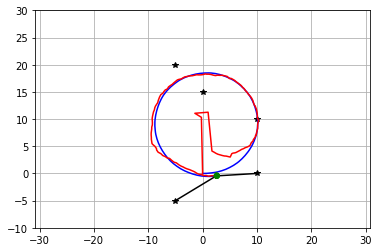

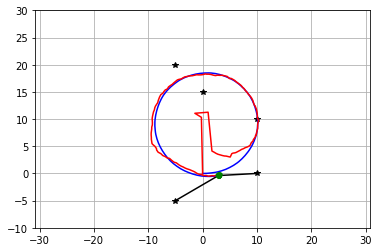

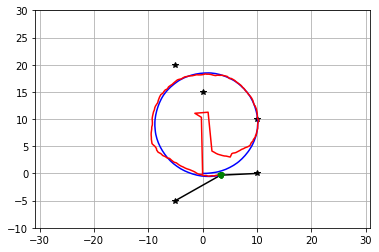

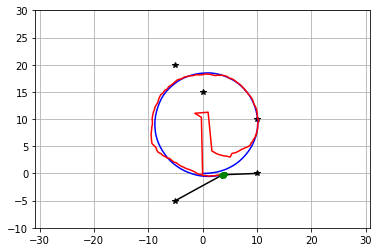

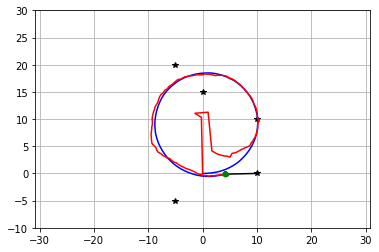

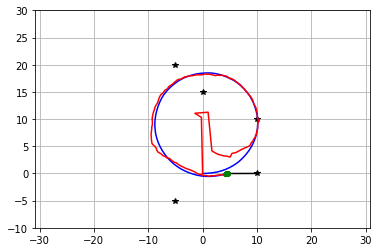

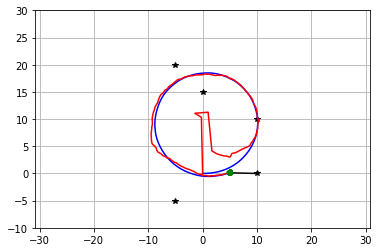

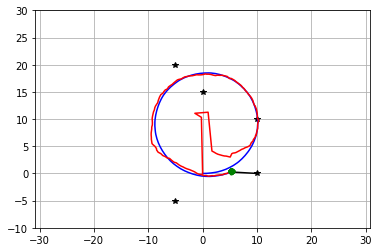

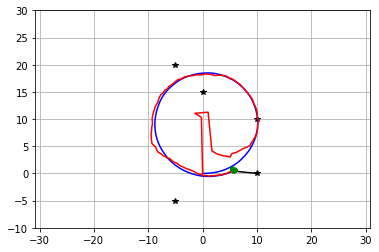

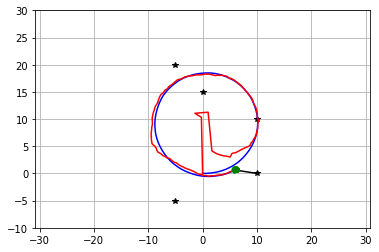

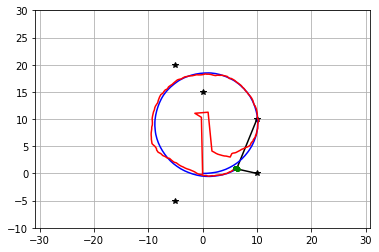

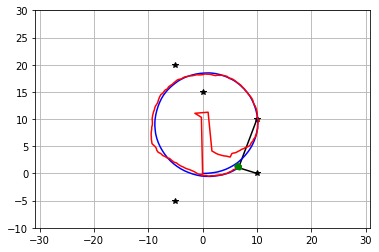

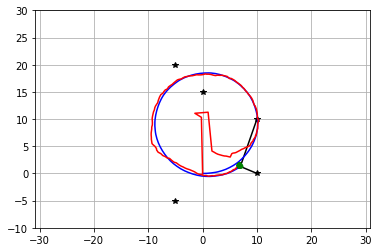

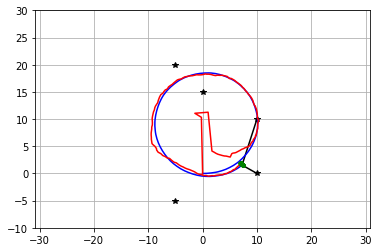

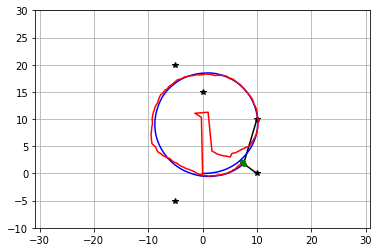

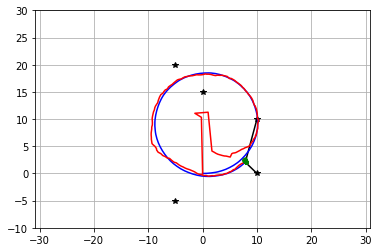

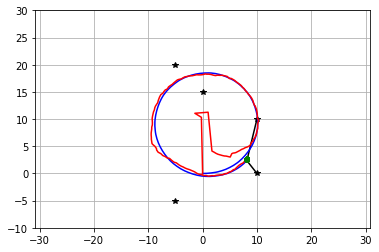

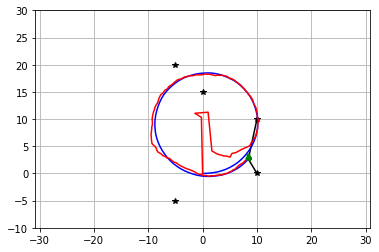

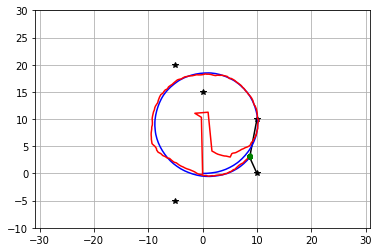

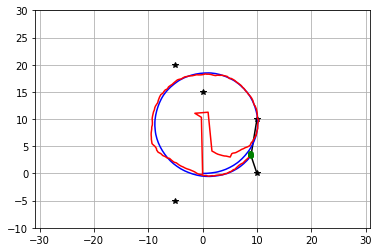

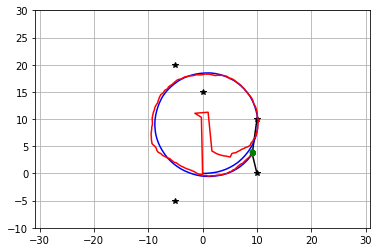

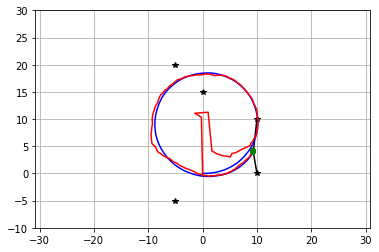

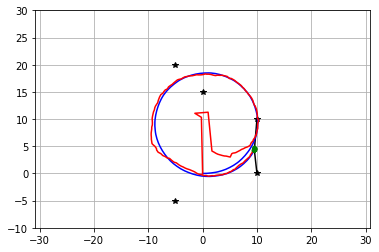

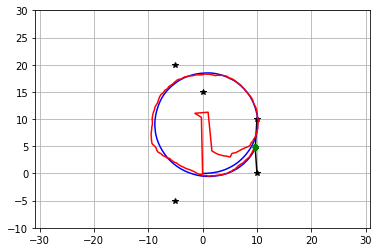

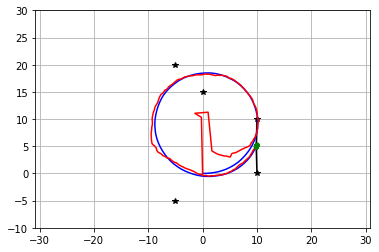

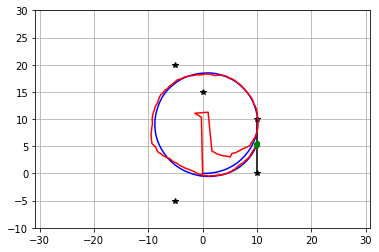

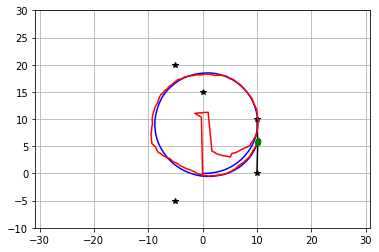

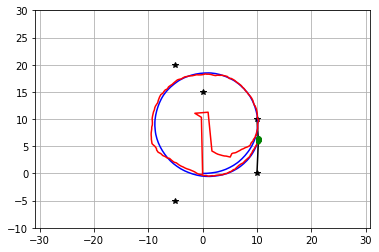

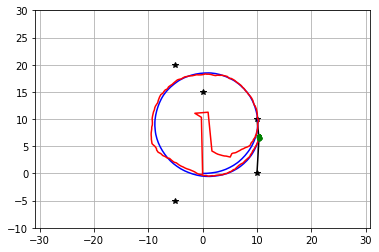

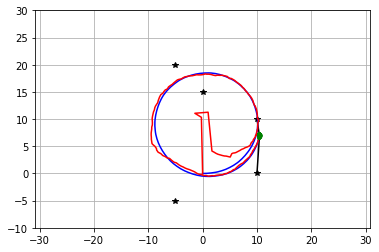

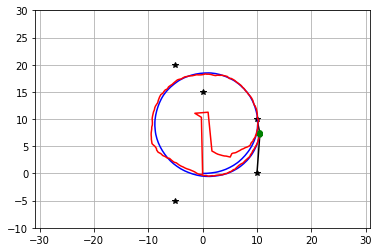

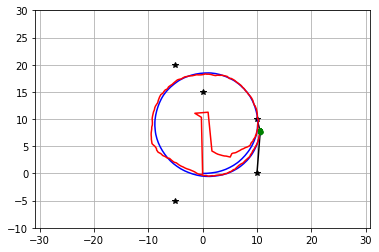

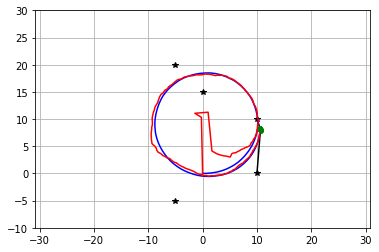

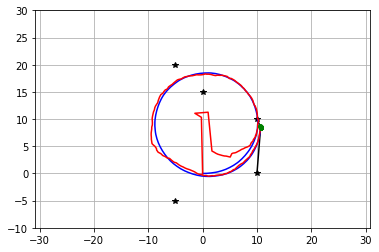

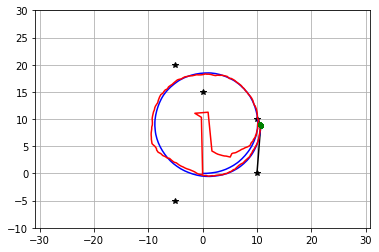

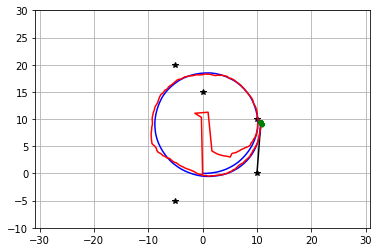

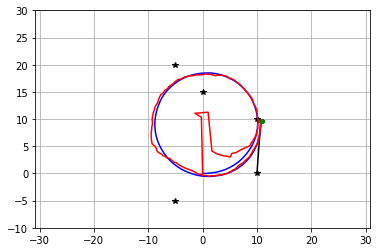

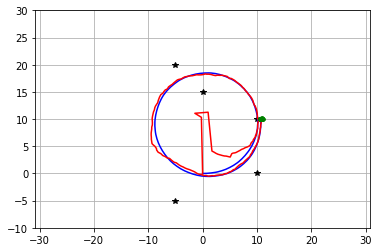

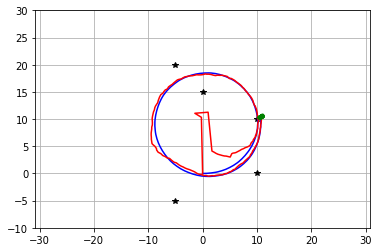

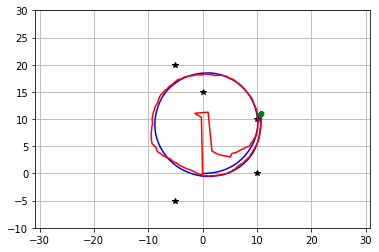

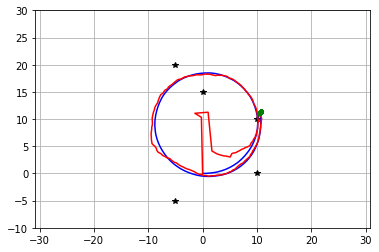

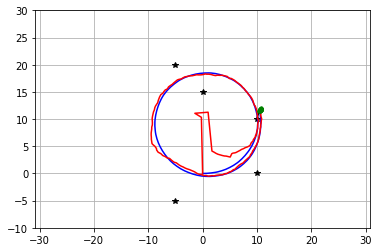

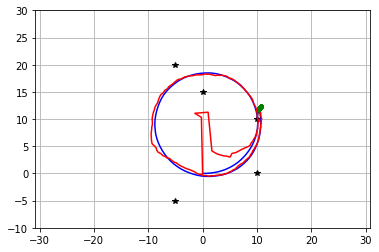

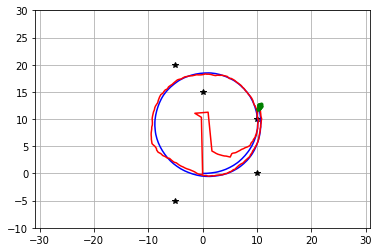

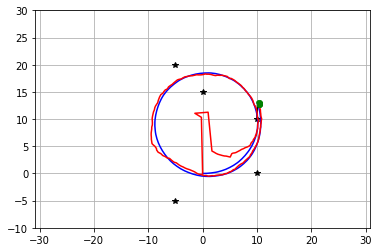

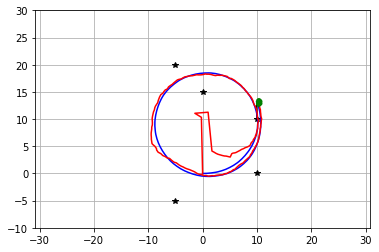

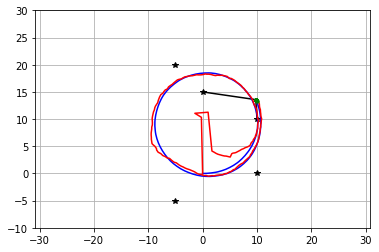

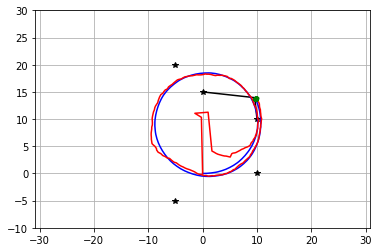

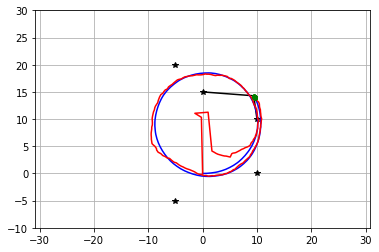

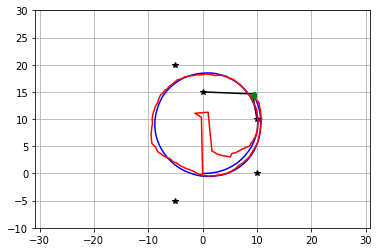

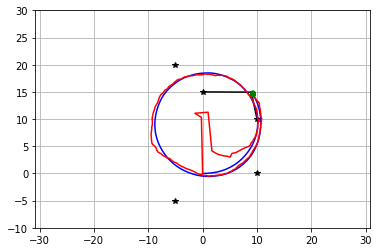

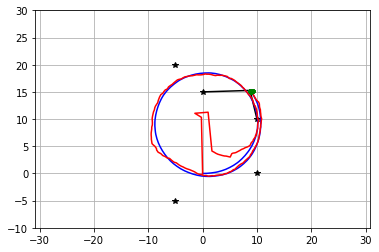

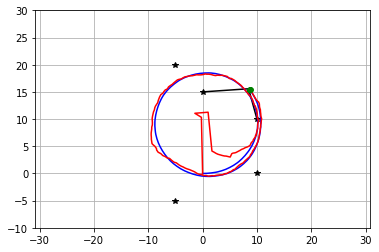

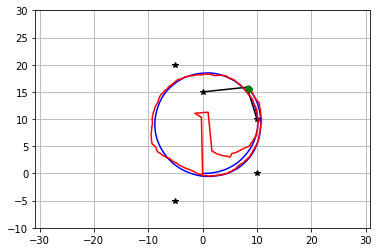

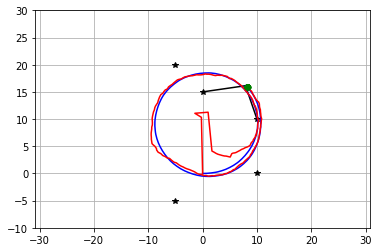

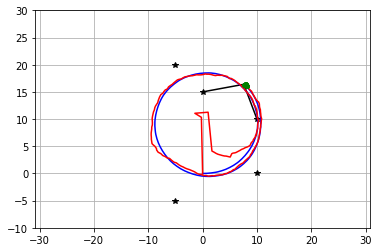

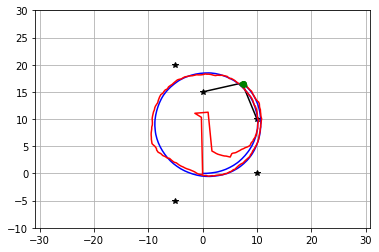

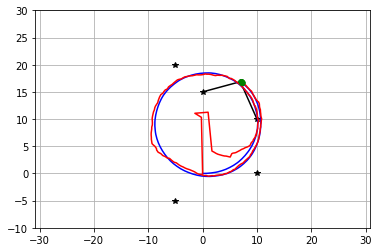

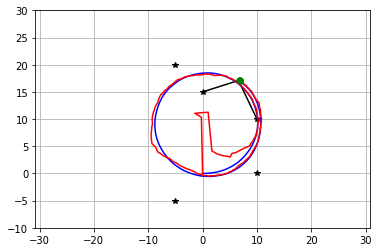

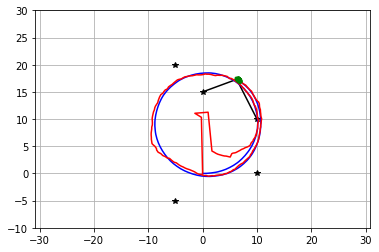

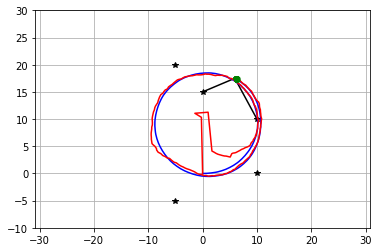

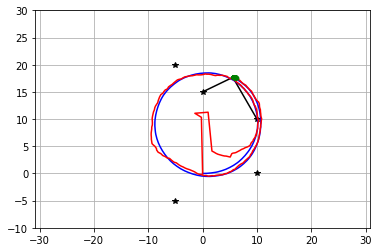

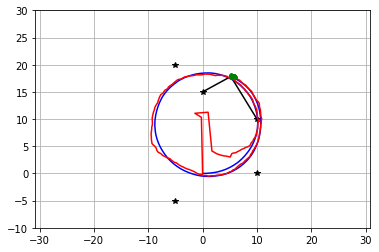

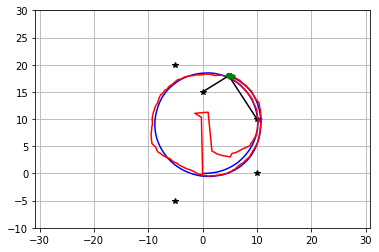

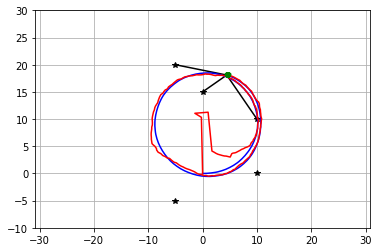

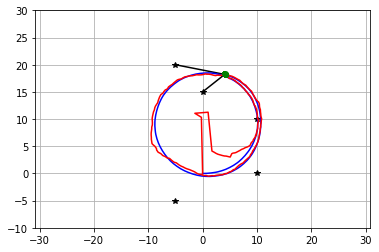

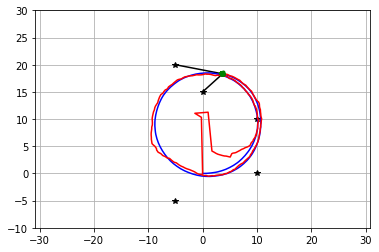

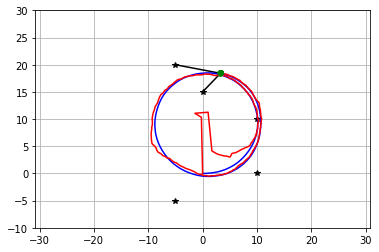

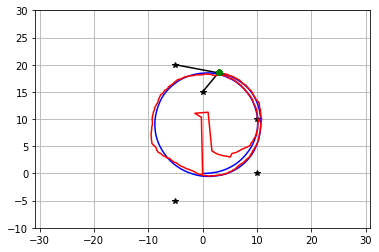

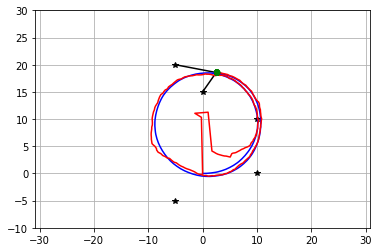

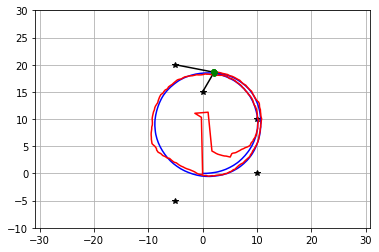

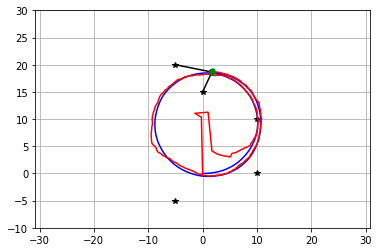

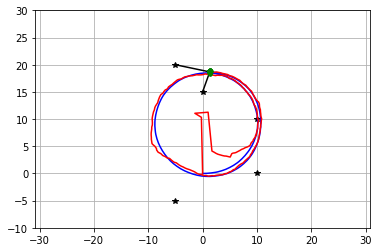

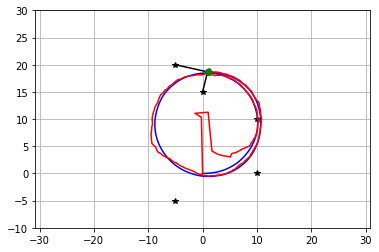

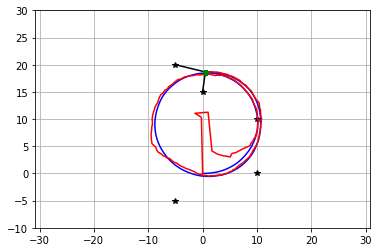

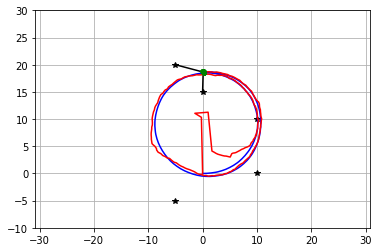

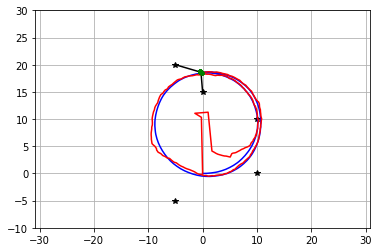

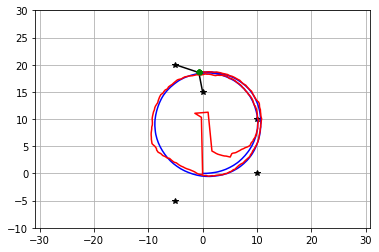

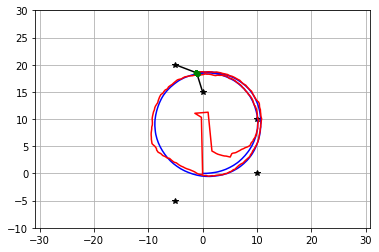

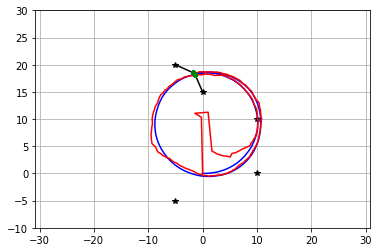

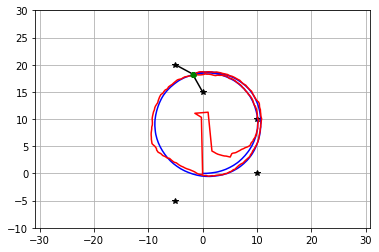

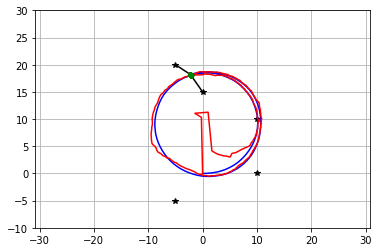

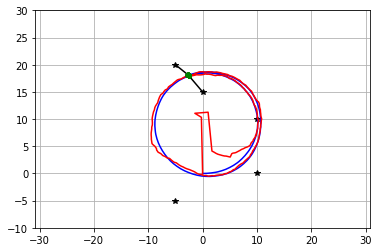

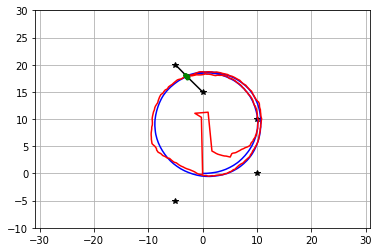

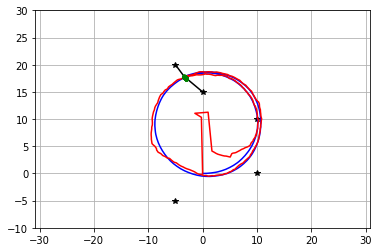

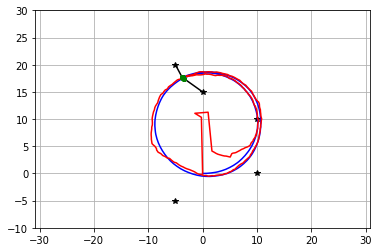

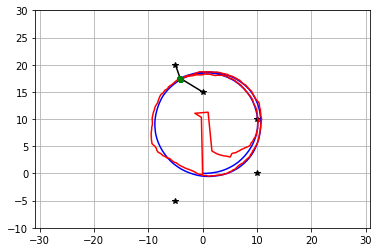

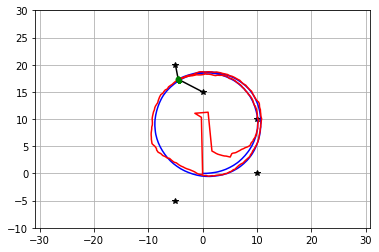

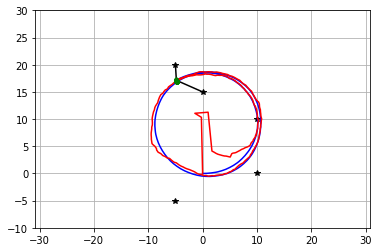

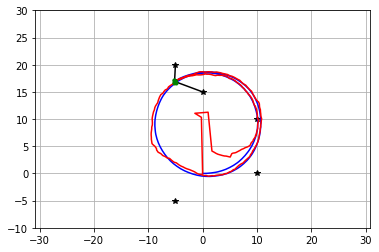

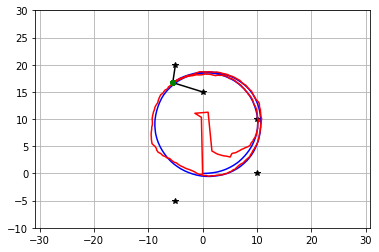

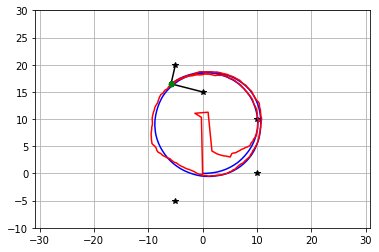

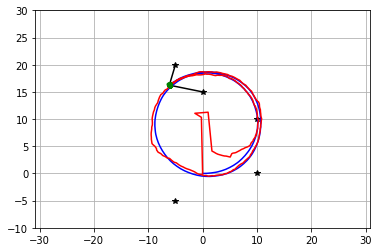

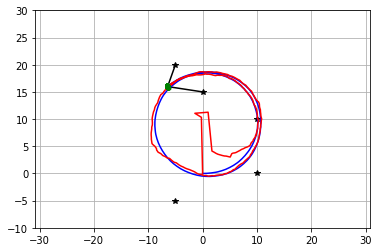

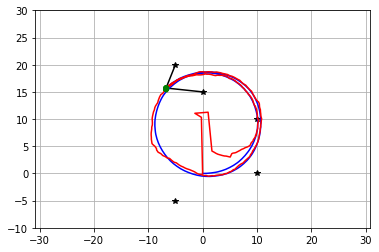

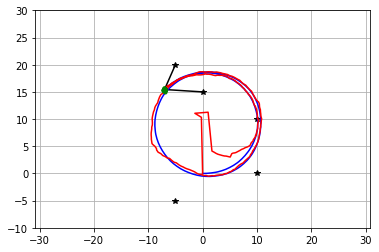

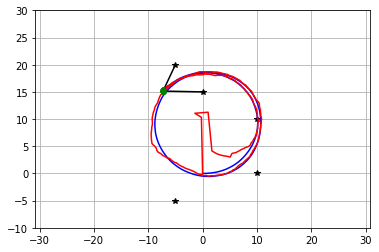

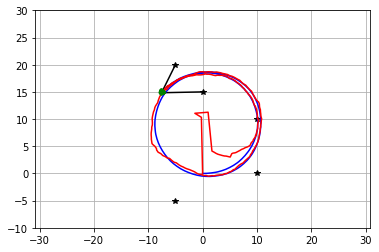

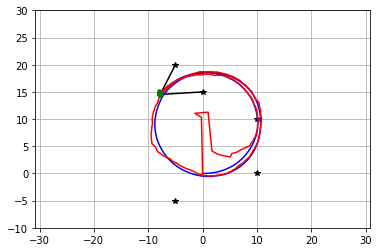

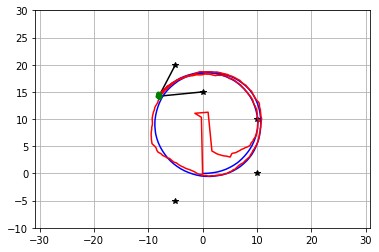

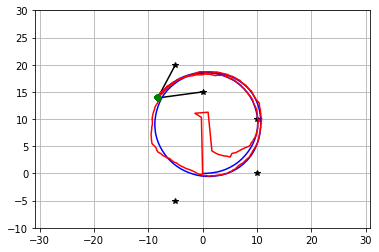

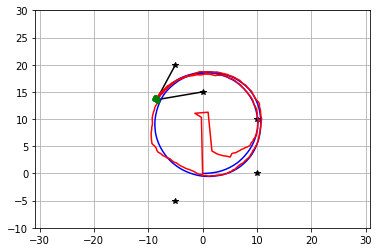

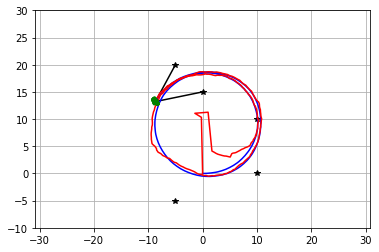

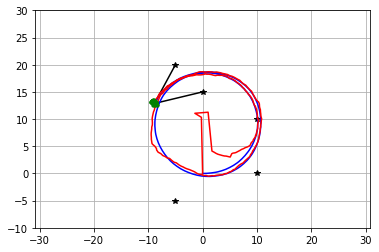

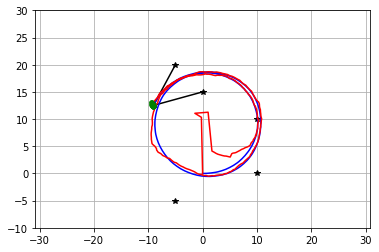

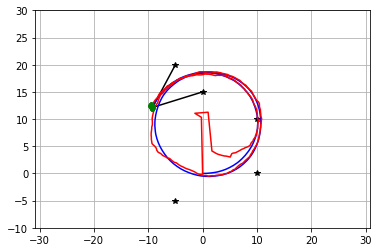

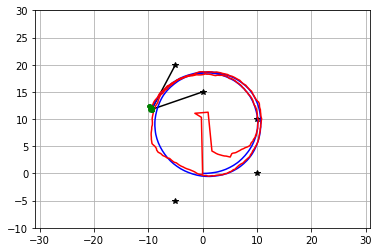

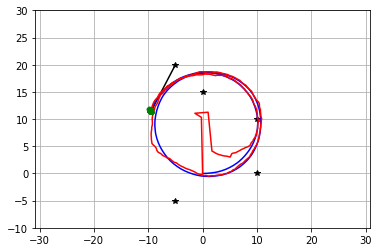

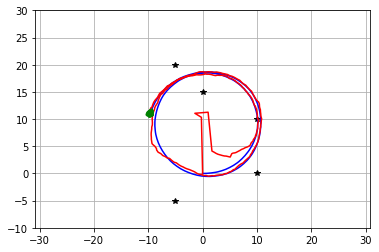

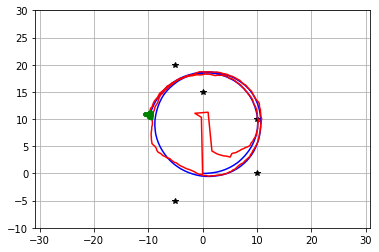

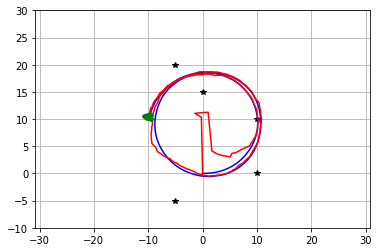

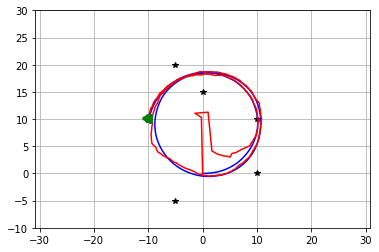

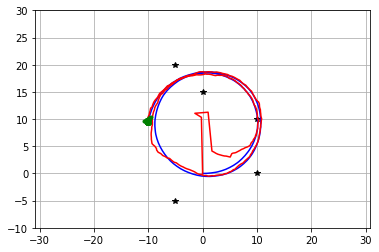

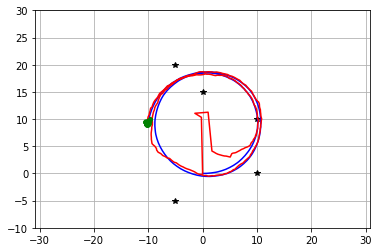

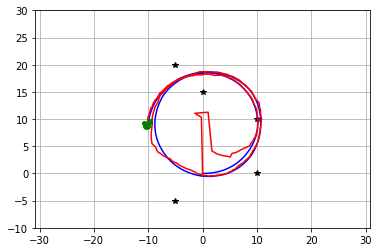

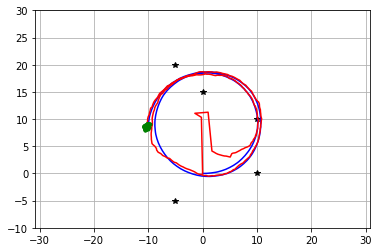

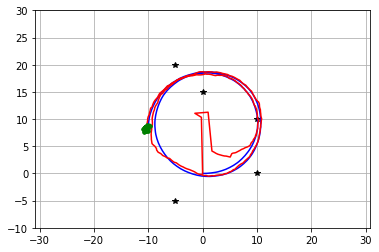

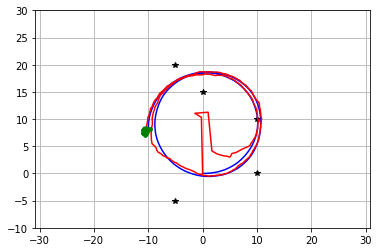

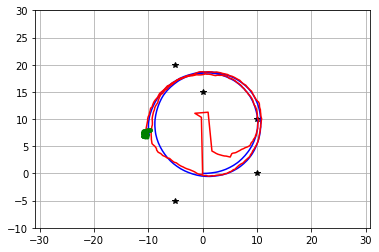

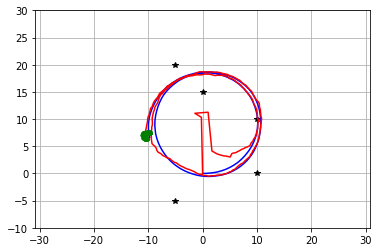

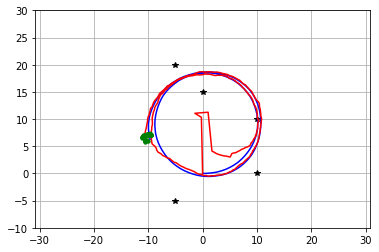

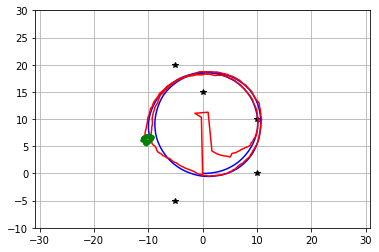

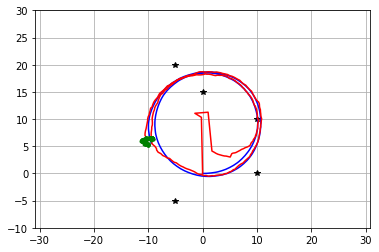

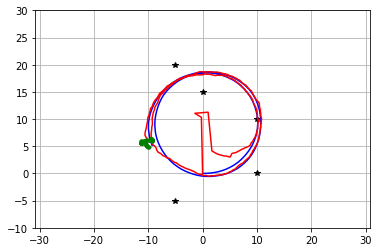

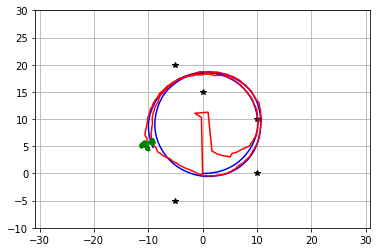

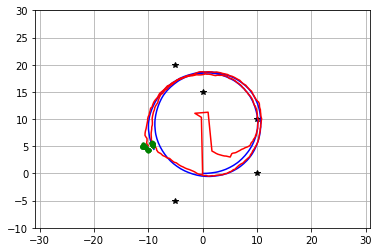

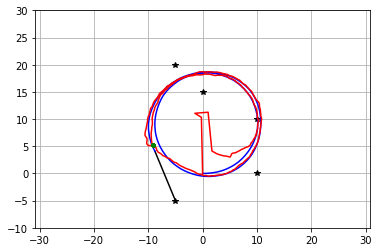

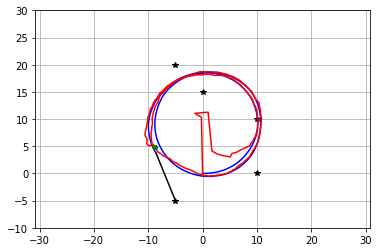

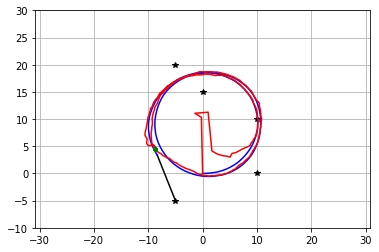

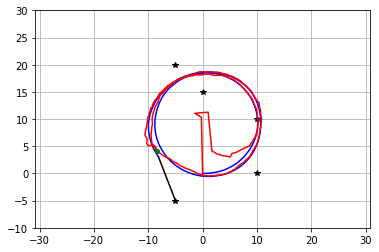

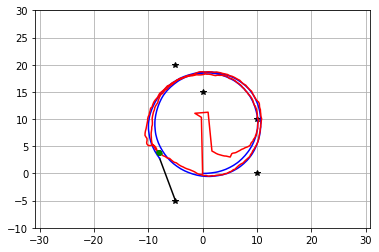

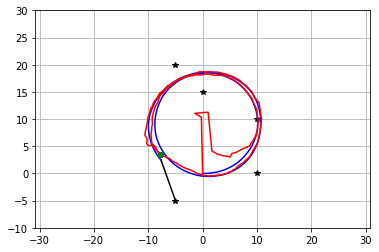

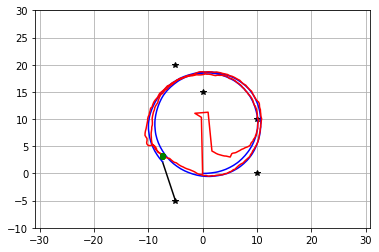

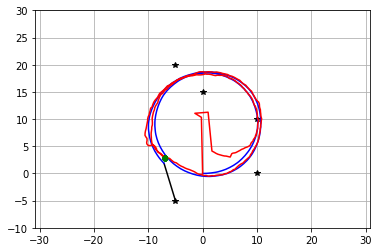

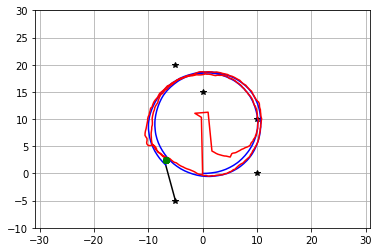

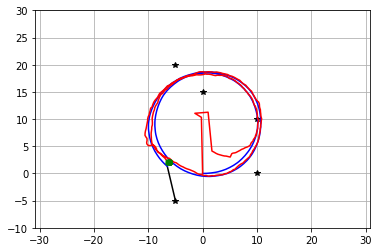

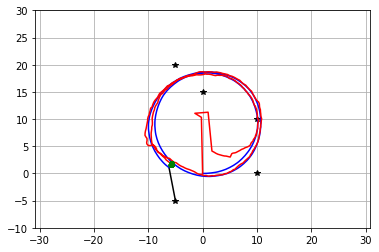

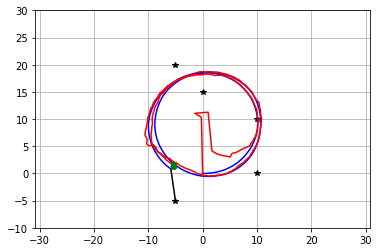

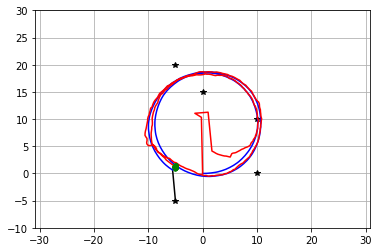

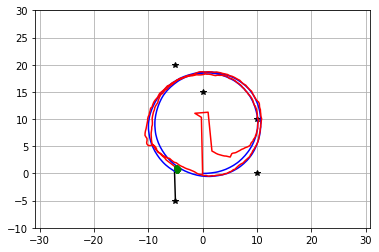

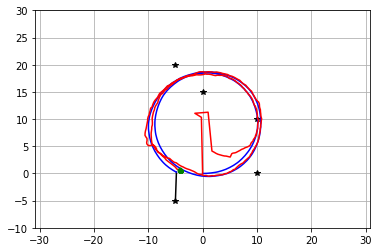

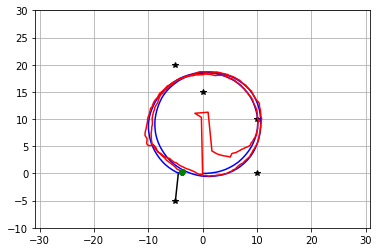

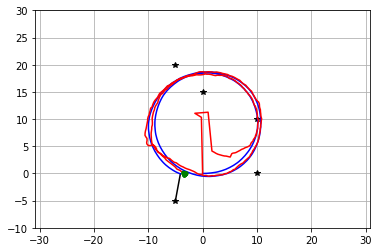

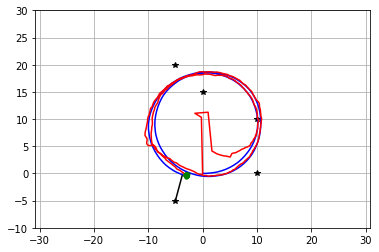

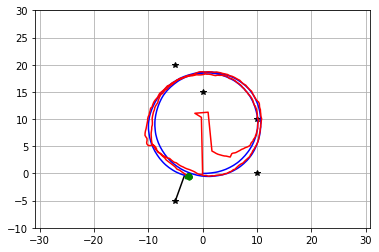

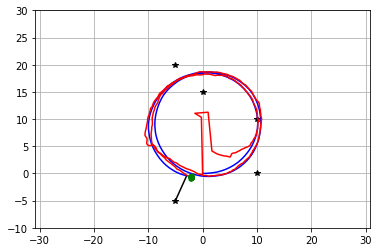

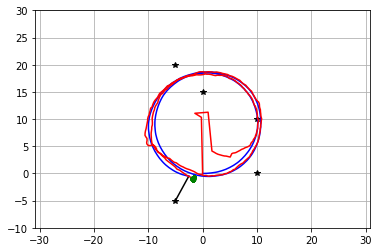

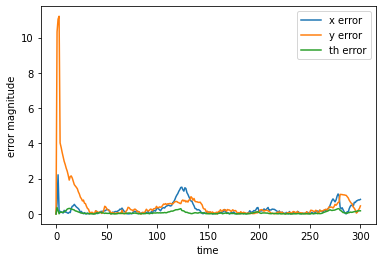

In [4]:
"""
COMS 4733 Spring 2021 Homework 4
Scaffolding code for localization using a particle filter
Inspired by a similar example on the PythonRobotics project
https://pythonrobotics.readthedocs.io/en/latest/
"""

import math
import matplotlib.pyplot as plt
import numpy as np

# Particle filter uncertainties
Q = np.diag([0.1, 0.1, np.deg2rad(1.0)]) ** 2
R = np.diag([0.4, np.deg2rad(1.0)]) ** 2
#Q = np.diag([0.01, 0.01, np.deg2rad(0.1)]) ** 2
#R = np.diag([4, np.deg2rad(10)]) ** 2


# Physical robot parameters
RHO = 1
L = 1
WHEEL1_NOISE = 0.05
WHEEL2_NOISE = 0.1
BEARING_SENSOR_NOISE = np.deg2rad(1.0)

# RFID positions [x, y]
RFID = np.array([[-5.0, -5.0],
                 [10.0, 0.0],
                 [10.0, 10.0],
                 [0.0, 15.0],
                 [-5.0, 20.0]])

DT = 0.1            # time interval [s]
SIM_TIME = 30.0     # simulation time [s]
MAX_RANGE = 10.0    # maximum observation range
#MAX_RANGE = 5
NP = 100            # Number of particles

# Plot limits
XLIM = [-20,20]
YLIM = [-10,30]
show_animation = True


"""
Robot physics
"""
def input(time, x):
    # Returns the control inputs to the robot at a given time for a given state
    psi1dot = 3.7
    psi2dot = 4.0
    return np.array([psi1dot, psi2dot])

def move(x, u):
    # Physical motion model of the robot: x_{k+1} = f(x_k, u_k)
    # Incorporates imperfections in the wheels
    theta = x[2]
    psi1dot = u[0] * (1 + np.random.rand() * WHEEL1_NOISE)
    psi2dot = u[1] * (1 + np.random.rand() * WHEEL2_NOISE)

    velocity = np.array([RHO/2 * np.cos(theta) * (psi1dot+psi2dot),
                         RHO/2 * np.sin(theta) * (psi1dot+psi2dot),
                         RHO/L * (psi2dot - psi1dot)])

    return x + DT * velocity

def measure(x):
    # Physical measurement model of the robot: z_k = h(x_k)
    # Incorporates imperfections in both range and bearing sensors
    z = np.zeros((0, 4))

    for i in range(len(RFID[:, 0])):
        dx = RFID[i, 0] - x[0]
        dy = RFID[i, 1] - x[1]
        r = math.hypot(dx, dy)
        phi = math.atan2(dy, dx) - x[2]

        if r <= MAX_RANGE:
            zi = np.array([[np.round(r),
                            phi + np.random.randn() * BEARING_SENSOR_NOISE,
                            RFID[i, 0], RFID[i, 1]]])
            z = np.vstack((z, zi))

    return z


"""
Particle filtering procedures
"""
def generate_particles():
    # Generate a set of NP particles with uniform weights
    p_x = np.random.uniform(XLIM[0], XLIM[1], NP)
    p_y = np.random.uniform(YLIM[0], YLIM[1], NP)
    p_th = np.random.uniform(-np.pi, np.pi, NP)

    px = np.vstack((p_x, p_y, p_th))
    pw = np.ones((1, NP)) / NP
    return px, pw


def localization(px, pw, z, u):
    # Particle filter procedures: Predict, update, resample when necessary
    for ip in range(NP):
        x = predict(px[:,ip], u)
        w = update(x, pw[0,ip], z)
        px[:,ip] = x
        pw[0,ip] = w

    if pw.sum() == 0:
        px, pw = generate_particles()

    pw = pw / pw.sum()
    x_est = px.dot(pw.T).flatten()

    N_eff = 1.0 / (pw.dot(pw.T))[0,0]
    if N_eff < NP/1.0:
        px = resample(px, pw)
        pw = np.ones((1, NP)) / NP

    return x_est, px, pw


# WRITE THIS FUNCTION
def predict(x, dpsi):
    """
    :param x: A size 3 NumPy array with the particle's state (x,y,theta)
    :param dpsi: A size 2 NumPy array with the robot's inputs (dpsi1, dpsi2)
    :return: The particle's updated state sampled from the motion model
    """

    noise = np.random.normal(0, np.sqrt(Q))
    x[0] = x[0] + DT*(RHO/2)*math.cos(x[2])*(dpsi[0]+dpsi[1]) + noise[0,0] 
    x[1] = x[1] + DT*(RHO/2)*math.sin(x[2])*(dpsi[0]+dpsi[1]) + noise[1,1]
    x[2] = x[2] + DT*(RHO/L)*(dpsi[1]-dpsi[0]) + noise[2,2]

    return x


#  WRITE THIS FUNCTION
def update(x, w, z):
    """
    :param x: A size 3 NumPy array with the particle's state (x,y,theta)
    :param w: The particle's current likelihood weight
    :param z: A (m by 4) NumPy array representing the m landmarks that the robot has observed;
    each row contains range, bearing, and landmark's true (x,y) location. Empty if no landmarks observed.
    :return: The particle's updated likelihood weight
    """
    prod = 1
    particle_x = x[0]
    particle_y = x[1]
    theta = x[2]

    R_det = np.linalg.det(R) #|R|
    R_inv = np.linalg.inv(R)

    # if there is no landmark observed, new weight = old weight
    if z.size == 0:
      return w
    
    for landmark in z:
      # each "landmark" contains range, bearing, and landmark's true (x,y) location
      # use landmark locations to predict range/bearing measurements
      r_measured = landmark[0]
      b_measured = landmark[1]
      true_x = landmark[2]
      true_y = landmark[3]

      # compute the predicted range of each landmark
      r_pred = np.sqrt((true_x-particle_x)**2+(true_y-particle_y)**2)
    
      # compute the predicted bearing of each landmark
      b_pred = np.arctan2((true_y-particle_y),(true_x-particle_x))-theta
    
      r_tilde = r_pred - r_measured # range
      
      phi_tilde = b_pred - b_measured # bearing
      obs_err = np.array([r_tilde, phi_tilde])
    
      prod *= (1/(2*math.pi*math.sqrt(R_det)))*math.exp((-1/2)*obs_err@R_inv@np.transpose(obs_err))

    w_new = w*prod
    
    return w_new


# WRITE THIS FUNCTION
def resample(px, pw):
    """
    :param px: A (3 by NP) NumPy array representing all the particles currently present
    :param pw: A size NP NumPy array with each particle's corresponding weight
    :return: A new set of particles obtained by sampling the original particles with given weights
    """
    # the px array corresponds to (x, y, theta)
    new_px = px
    N = len(pw[0]) # length of the weights

    # use np.random to "reshuffle" particles and generate new indices from pw
    idx = np.random.choice(N, size = N, replace = True, p=pw[0])

    i=0
    for j in idx:
      new_px[0][i]=px[0][j]
      new_px[1][i]=px[1][j]
      new_px[2][i]=px[2][j]
      i+=1

    # return the new particle set
    return new_px


def main():
    time = 0.0

    # State Vector [x y theta]'
    x_est = np.zeros(3)
    x_true = np.zeros(3)

    # history
    h_x_est = x_est.T
    h_x_true = x_true.T

    px, pw = generate_particles()

    while SIM_TIME >= time:
        time += DT
        u = input(time, x_true)
        x_true = move(x_true, u)
        z = measure(x_true)
        x_est, px, pw = localization(px, pw, z, u)

        # store data history
        h_x_est = np.vstack((h_x_est, x_est))
        h_x_true = np.vstack((h_x_true, x_true))

        if show_animation:
            plt.cla()

            for i in range(len(z[:,0])):
                plt.plot([x_true[0], z[i,2]], [x_true[1], z[i,3]], "-k")
            plt.plot(RFID[:,0], RFID[:,1], "*k")
            plt.plot(np.array(h_x_true[:,0]).flatten(), np.array(h_x_true[:,1]).flatten(), "-b")
            # Uncomment the following lines after you finish implementing the particle filter
            plt.plot(np.array(h_x_est[:,0]).flatten(), np.array(h_x_est[:,1]).flatten(), "-r")
            plt.plot(px[0,:], px[1,:], ".g")

            plt.axis("equal")
            plt.xlim(XLIM)
            plt.ylim(YLIM)
            plt.grid(True)
            plt.pause(0.001)

    plt.figure()
    errors = np.abs(h_x_true - h_x_est)
    dth = errors[:,2] % (2*np.pi)
    errors[:,2] = np.amin(np.array([2*np.pi-dth, dth]), axis=0)
    plt.plot(errors)
    plt.legend(['x error', 'y error', 'th error'])
    plt.xlabel('time')
    plt.ylabel('error magnitude')
    #plt.ylim([0,1.5])
    plt.show()


if __name__ == '__main__':
    main()
